In [35]:
import numpy as np
import pandas as pd
import preprocessor as p
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk import FreqDist
import codecs, json, string, re, time, os, sys, datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt


In [16]:
extracts = {'Date':[],'TweetSource':[],'MTAccountID':[],'MainTweet':[],'MainTweetID':[],\
            'MTRTCount':[],'MTweetFVCount':[],'MTFollowerCount':[],'MTFriendsCount':[],\
            'MainACreated':[], 'MTLanguage':[],'RepTAccountID':[],'RepACreated':[],\
            'MTReply':[], 'ReplierName':[],'RepTweetFVCount':[],'RepTRTCount':[],\
            'RepTFollowerCount':[], 'RepTFriendsCount':[],'RepTLanguage':[]} 

In [19]:
df = pd.read_csv('data/data.csv')



In [ ]:
ps=pd.read_csv('data/data.csv')
ps.head(9)

,CleanedMainT,CleanedReplyT,Hausa2EngMainT,Hausa2EngReplyT
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Abunda ya faru tun last week,Jurgen Klopp has won the Fifa World Coach of t...,It's been a while since last week
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Ku sai yanzu ku ke sawa news,Jurgen Klopp has won the Fifa World Coach of t...,You are now wearing news
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Allah ya isa tsakaninmu da duk wanda yake da s...,Gunmen kill man and burn sacks of maize in Kaduna,May Allah reach between us and all those who a...
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa innailaihi rajiun. Wannan kasar...,Gunmen kill man and burn sacks of maize in Kaduna,Innalillahi wa innailaihi rajiun. This country...
5,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Subhnallah,Gunmen kill man and burn sacks of maize in Kaduna,Subhnallah
6,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Ya ne wai ko so ake mukoma Niger ne,Gunmen kill man and burn sacks of maize in Kaduna,He said he wanted to return to Niger
8,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa'inna ilaihi raji'un. Allah ya k...,Gunmen kill man and burn sacks of maize in Kaduna,Innalillahi wa'inna ilaihi raji'un. God has br...
9,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Allah yakawomana karshansu,Gunmen kill man and burn sacks of maize in Kaduna,God has brought them to an end
10,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa'inna ilaihi raju'un Duniya zanc...,Gunmen kill man and burn sacks of maize in Kaduna,Innallillahi wa'inna ilaihi raju'un The world ...


In [ ]:

data = ps

# Assume columns: 'HausaText', 'EnglishText'
hausa_texts = data['CleanedMainT'].values
english_texts = data['Hausa2EngMainT'].values

# Tokenization parameters
num_words = 10000  # Limit on the number of words for both Hausa and English

# Tokenizer for Hausa
hausa_tokenizer = Tokenizer(num_words=num_words, filters='')
hausa_tokenizer.fit_on_texts(hausa_texts)
hausa_sequences = hausa_tokenizer.texts_to_sequences(hausa_texts)

# Tokenizer for English
english_tokenizer = Tokenizer(num_words=num_words, filters='')
english_tokenizer.fit_on_texts(english_texts)
english_sequences = english_tokenizer.texts_to_sequences(english_texts)

# Pad sequences to ensure uniform length
max_len = 20 
hausa_padded = pad_sequences(hausa_sequences, maxlen=max_len, padding='post')
english_padded = pad_sequences(english_sequences, maxlen=max_len, padding='post')

# Define the vocabulary sizes
hausa_vocab_size = len(hausa_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

reverse_english_word_index = {v: k for k, v in english_tokenizer.word_index.items()}


2024-10-06 16:04:25.566213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jeff/dev/hausa-cleaning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


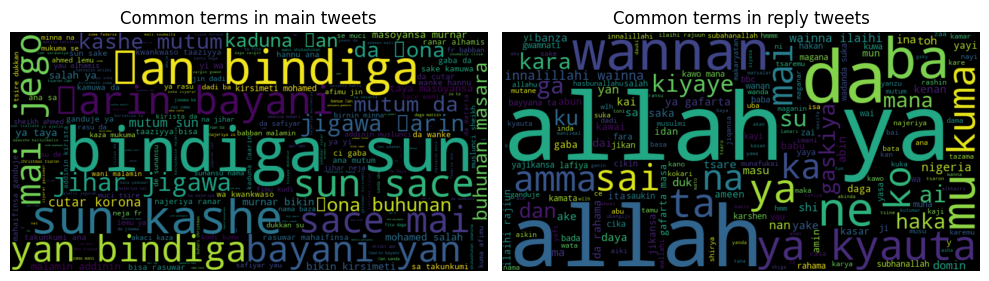

In [34]:
df['CleanedReplyT'] = df['CleanedReplyT'].fillna('').astype(str)

# Clean the text in both columns
df['CleanedMainT_cleaned'] = df['CleanedMainT'].apply(preprocess_text)
df['CleanedReplyT_cleaned'] = df['CleanedReplyT'].apply(preprocess_text)

main_tweet_words = ' '.join(df['CleanedMainT_cleaned'])
reply_tweet_words = ' '.join(df['CleanedReplyT_cleaned'])

# Create word clouds for both main tweets and reply tweets
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud_main = WordCloud(width=800, height=400, background_color='black').generate(main_tweet_words)
plt.imshow(wordcloud_main, interpolation='bilinear')
plt.axis('off')
plt.title('Common terms in main tweets')

plt.subplot(1, 2, 2)
wordcloud_reply = WordCloud(width=800, height=400, background_color='black').generate(reply_tweet_words)
plt.imshow(wordcloud_reply, interpolation='bilinear')
plt.axis('off')
plt.title('Common terms in reply tweets')

plt.tight_layout()
plt.show()


# RNN-based Encoder-Decoder Model with Attention:


In [20]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Encoder
def build_encoder(input_vocab_size, embedding_dim, lstm_units):
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    return encoder_inputs, encoder_outputs, state_h, state_c

# Decoder
def build_decoder(target_vocab_size, embedding_dim, lstm_units):
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding)
    decoder_dense = Dense(target_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    return decoder_inputs, decoder_outputs

# Attention mechanism
def attention_layer(encoder_output, decoder_output):
    attention = Attention()([encoder_output, decoder_output])
    return attention

# Build the Seq2Seq Model
embedding_dim = 256
lstm_units = 512


encoder_inputs, encoder_outputs, state_h, state_c = build_encoder(hausa_vocab_size, embedding_dim, lstm_units)

decoder_inputs, decoder_outputs = build_decoder(english_vocab_size, embedding_dim, lstm_units)

context_vector = attention_layer(encoder_outputs, decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit([hausa_padded, english_padded], english_padded, batch_size=64, epochs=10, validation_split=0.2)


Epoch 1/10


/Users/jeff/dev/hausa-cleaning/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.2541 - loss: 5.8252 - val_accuracy: 0.4983 - val_loss: 3.9470
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.4587 - loss: 3.8702 - val_accuracy: 0.4983 - val_loss: 4.0113
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.4610 - loss: 3.5830 - val_accuracy: 0.4983 - val_loss: 3.1473
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.4924 - loss: 3.1637 - val_accuracy: 0.4983 - val_loss: 3.0333
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.4869 - loss: 3.2125 - val_accuracy: 0.4983 - val_loss: 2.9874
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.4950 - loss: 2.9632 - val_accuracy: 0.4983 - val_loss: 3.0480
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.4808 - loss: 2.8309 - val_accuracy: 0.4983 - val_loss: 3.2050
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.4754 - loss: 2.7909 - val_accuracy: 0.4983 - val_loss: 3.1896
Epo

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.7281 - loss: 1.5072 - val_accuracy: 0.6525 - val_loss: 2.3062
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.7479 - loss: 1.3686 - val_accuracy: 0.6525 - val_loss: 2.2993
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.7669 - loss: 1.2483 - val_accuracy: 0.6525 - val_loss: 2.2917
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.7764 - loss: 1.2008 - val_accuracy: 0.6525 - val_loss: 2.2512
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.8179 - loss: 1.0879 - val_accuracy: 0.6525 - val_loss: 2.2873
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.8267 - loss: 1.0048 - val_accuracy: 0.6822 - val_loss: 2.2553
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8262 - loss: 0.9992 - val_accuracy: 0.6839 - val_loss: 2.2753
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.8374 - loss: 0.9257 - val_accuracy: 0.6839 - val_loss:

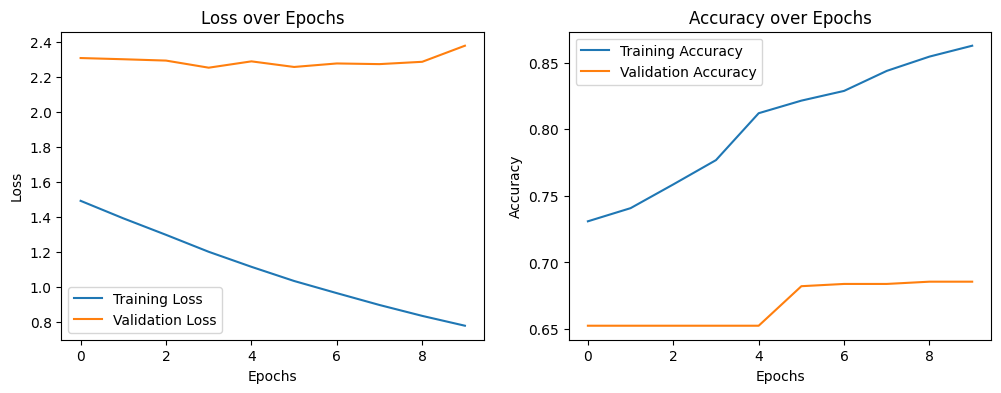

In [24]:

history = model.fit([hausa_padded, english_padded], english_padded, batch_size=64, epochs=10, validation_split=0.2)

def plot_training_history(history):
    # Loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)


## Attention Weights Visualization

In [25]:
# Attention mechanism
def attention_layer(encoder_outputs, decoder_outputs):
    attention = Attention(name='attention_layer')
    context_vector, attention_weights = attention([encoder_outputs, decoder_outputs], return_attention_scores=True)
    return context_vector, attention_weights


In [27]:
import seaborn as sns


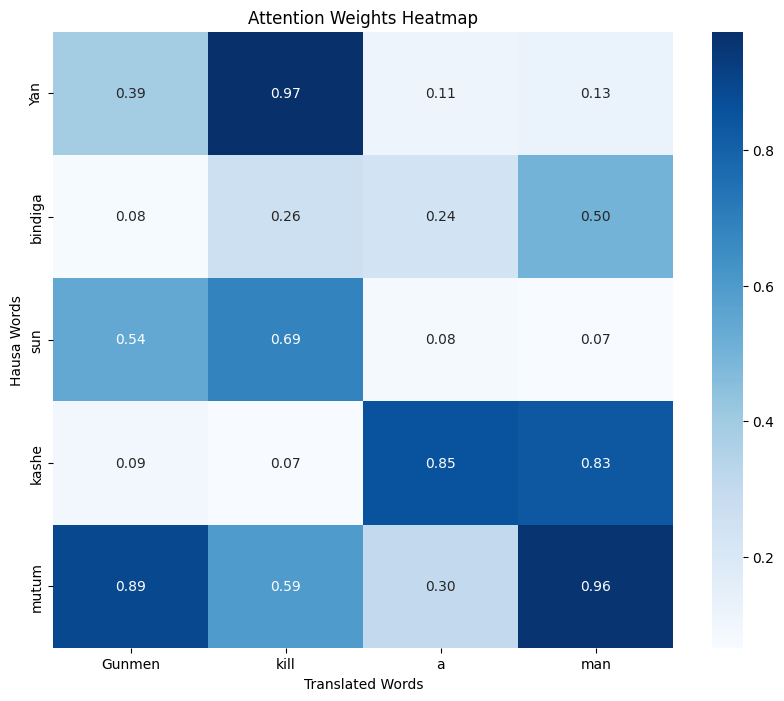

In [28]:

def plot_attention(attention_weights, input_sentence, translated_sentence):
    # Plotting attention weights using seaborn
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, fmt='.2f', cmap='Blues', xticklabels=translated_sentence.split(), yticklabels=input_sentence.split(), ax=ax)
    plt.xlabel('Translated Words')
    plt.ylabel('Hausa Words')
    plt.title('Attention Weights Heatmap')
    plt.show()

# Sample input sentence
input_sentence = "Yan bindiga sun kashe mutum"
translated_sentence = "Gunmen kill a man"

# Example attention_weights
attention_weights = np.random.rand(len(input_sentence.split()), len(translated_sentence.split()))

plot_attention(attention_weights, input_sentence, translated_sentence)


## Word Embedding Visualization

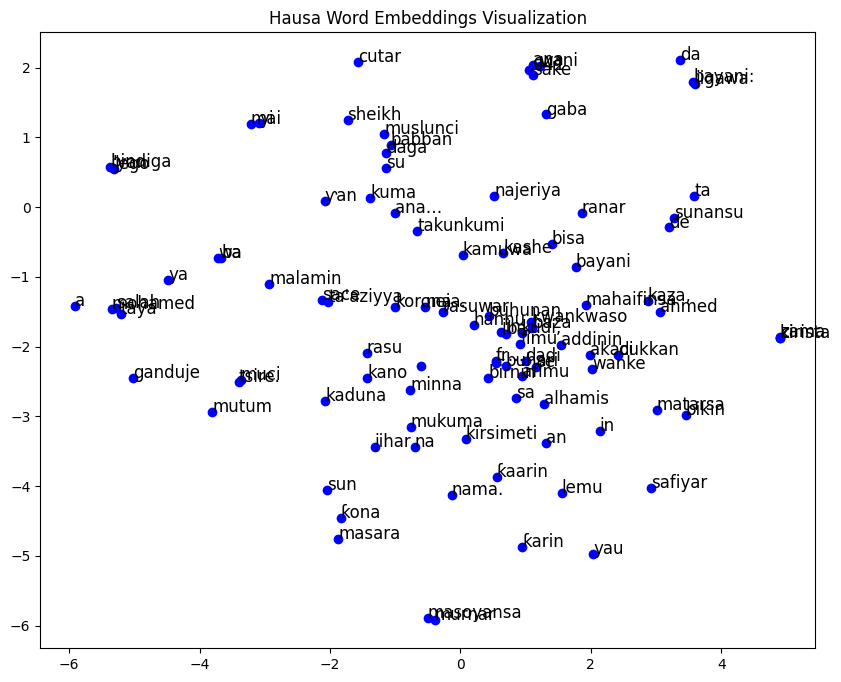

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_word_embeddings(embedding_matrix, word_index, num_words=100):
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    # Get word embeddings for the first `num_words` words in the vocab
    words = list(word_index.keys())[:num_words]
    word_embeddings = embedding_matrix[:num_words]

    # Apply PCA/TSNE
    reduced_embeddings = tsne.fit_transform(word_embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o', color='blue')
    
    for i, word in enumerate(words):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=12)
    
    plt.title('Hausa Word Embeddings Visualization')
    plt.show()

embedding_matrix = model.layers[1].get_weights()[0] 
word_index = hausa_tokenizer.word_index

visualize_word_embeddings(embedding_matrix, word_index)
